# Comparing end-to-end throughput using different channel estimation methods

In [1]:
import numpy as np
import time, os, torch
import matplotlib.pyplot as plt

from neoradium import Carrier, PDSCH, CdlChannel, AntennaPanel, Grid, random, LdpcEncoder, HarqEntity, SnrScheduler

from ChEstNet import ChEstNet
from ChEstUtils import estimateChannelML, getPseudoPilotIndices

In [2]:
# Load the model:
modelPath = 'Models/BestModel.pth'
device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model = ChEstNet(device)                                # Instantiate the model on the target device
model.loadParams(modelPath);                            # Load the trained model parameters

In [3]:
# Add New functions to HARQ. 
from neoradium.harq import HarqProcess, HarqCW 
def decodeLLRs2cw(self, llrs, txBlockSize, numIter):
    # Uses the LdpcDecoder's methods to decode the 'llrs'
    decoder = self.process.entity.decoder                           # Get LDPC decoder object from the HARQ entity

    # Save the current buffer and restore it after returning from recoverRate.
    savedBuffer = None if self.decBuffer is None else np.copy(self.decBuffer)
    rxCodedBlocks = decoder.recoverRate(llrs, txBlockSize, self)          # Recover Rate
    self.decBuffer = savedBuffer
    decodedBlocks = decoder.decode(rxCodedBlocks, numIter=numIter)            # LDPC Decoding
    decodedTxBlockWithCRC, crcMatch = decoder.checkCrcAndMerge(decodedBlocks) # Check code block CRCs and Merge them
    return decodedTxBlockWithCRC, crcMatch
HarqCW.decodeLLRs2 = decodeLLRs2cw

def decodeLLRs2Pr(self, llrs, txBlockSizes, numIter=5):
    retvals = [cw.decodeLLRs2(llrs[i], txBlockSizes[i], numIter) for i,cw in enumerate(self.cws)]
    return tuple(list(x) for x in zip(*retvals))   # returns a tuple of lists for decodedTxBlocks, blockErrors
HarqProcess.decodeLLRs2 = decodeLLRs2Pr

def decodeLLRsEn(self, llrs, txBlockSize, numIter=5):
    if not isinstance(llrs,list):
        retVals = self.curProcess.decodeLLRs2([llrs], [txBlockSize], numIter)
        return retVals[0][0], retVals[1][0]
    return self.curProcess.decodeLLRs2(llrs, txBlockSize, numIter)
HarqEntity.decodeLLRs2 = decodeLLRsEn

In [4]:
# Calculate Throughput with HARQ
seed = 123
# Note:
# Using maxSlots = 3000 may cause this experiment to take a long time to complete.
# You can use a smaller value to obtain quicker (though less precise) results.
maxSlots = 3000                             # Number of Slots
snrScheduler = SnrScheduler(-8,0.2)         # Start at -13 dB, use increments of 0.2 dB

freqDomain = True                           # Set to True to apply channel in frequency domain
modulation = "16QAM"
codeRate = 490/1024
numLayers = 2

carrier = Carrier(numRbs=45, spacing=30)    # Create a carrier with 45 RBs and 30KHz subcarrier spacing
bwp = carrier.curBwp                        # The only bandwidth part in the carrier

# Create a 2-layer PDSCH object with type-2 DMRS on symbols 2 and 11
pdsch = PDSCH(bwp, numLayers=numLayers, nID=carrier.cellId, modulation=modulation)
pdsch.setDMRS(configType=2, additionalPos=1) # Specify the DMRS configuration

# Create the LDPC encoder and decoder:
ldpcEncoder = LdpcEncoder(baseGraphNo=1, modulation=pdsch.modems[0].modulation, 
                          txLayers=pdsch.numLayers, targetRate=codeRate)

# HARQ configuration:
harqType = "CC"                                     # This currently work only with Chase Combining (CC)
numProc = 16                                        # Number of HARQ processes
harq = HarqEntity(ldpcEncoder, harqType, numProc)   # Create the HARQ entity

channel = CdlChannel(bwp, 'C', delaySpread=300, carrierFreq=4e9, dopplerShift=5,
                     txAntenna = AntennaPanel([2,4], polarization="x"),  # 16 TX antenna
                     rxAntenna = AntennaPanel([1,2], polarization="x"))  # 4 RX antenna

def equalizeAndDecode(rxGrid, chanEst):
    eqGrid, llrScales = rxGrid.equalize(chanEst)           # Equalization
    llrs = pdsch.getLLRsFromGrid(eqGrid, pdsch.dataIndices, llrScales)     
    decodedTxBlockWithCRC, crcMatch = harq.decodeLLRs2(llrs[0], txBlockSizes[0], numIter=2)
    blockErrors = len(crcMatch)-sum(crcMatch)
    return [0, 0, blockErrors, len(crcMatch)], [decodedTxBlockWithCRC, crcMatch]

chEstMethods = ["LS", "Self-Refining", "Perfect"]
results = {}

for chEstMethod in chEstMethods:
    print(f'\nCalculating Throughput for "{chEstMethod}" channel estimation')
    print("SNR(dB)  Tx Bits     Rx Bits     Throughput(%)  TX Blocks  RX Blocks  BLER(%)  Retry Mean  time(Sec.)")
    print("-------  ----------  ----------  -------------  ---------  ---------  -------  ----------  ----------")

    snrScheduler.reset()
    for snrDb in snrScheduler:
        random.setSeed(seed)
        channel.restart()                                           # Reset the channel and the bandwidth part associated with it
        harq.reset()                                                # Reset HARQ state and buffers
        retransmissionsSaved = 0
    
        t0 = time.time()                                            # Start the timer
        for s in range(maxSlots):                                   # The inner loop doing 'numSlot' transmissions
            grid = bwp.createGrid(pdsch.numLayers)                  # Create a resource grid with 2 layers
            pdsch.allocateResources(grid)                           # Allocat PDSCH resources including DMRS
            txBlockSizes = pdsch.getTxBlockSize(codeRate)           # Calculate the Transport Block Size (TBS)
            numBits = pdsch.getBitSizes(grid)                       # Total number of PDSCH data bits available in the resource grid
    
            # Preparing the transport blocks
            txBlocks = []                                           # Transport blocks, one per codeword.
            for c in range(harq.numCW):
                if harq.needNewData[c]:                             # New transmission.
                    txBlocks += [ random.bits(txBlockSizes[c]) ]    # Create random bits for new transmissions
                else:                                               # Retransmission
                    txBlocks += [ None ]                            # Set transport block to None to indicate a retransmission
    
            # The following function returns a coded, rate-matched bitstream, ready for transmission/retransmission
            rateMatchedCodeBlocks = harq.getRateMatchedCodeBlocks(txBlocks, numBits)    
            
            pdsch.populateGrid(grid, rateMatchedCodeBlocks)         # Map/modulate the data to the resource grid
            channelMatrix = channel.getChannelMatrix()              # Get perfect channel matrix
            precoder = pdsch.getPrecodingMatrix(channelMatrix)      # Get precoding matrix based on perfectChannelMatrix

            precodedGrid = grid.precode(precoder)                   # Perform precoding
            rxGrid = precodedGrid.applyChannel(channelMatrix)       # Apply the channel to the precoded resource (Freq. domain)
            noisyRxGrid = rxGrid.addNoise(snrDb=snrDb)              # Add noise to get a noisy received resource grid
                     
            if chEstMethod == "Perfect":
                pcChannelMatrix = channelMatrix @ precoder[None,...]     # Calculate the channel matrix with the precoding effect. 

            elif chEstMethod == "LS":
                pcChannelMatrix, noiseEst = noisyRxGrid.estimateChannelLS(pdsch.dmrs, polarInt=True, kernel='linear')

            elif chEstMethod == "Self-Refining":              
                # ML using DMRS only
                pilotsGrid = pdsch.getGrid()    # In practice we do not have access to the txGrid in the receiver
                dmrsIdx = pilotsGrid.getReIndexes("DMRS")
                pcChannelMatrix = estimateChannelML(model, dmrsIdx, pilotsGrid, noisyRxGrid)
                berBlerInfo, decodeInfo = equalizeAndDecode(noisyRxGrid, pcChannelMatrix)

                blockErrors, numCB = berBlerInfo[2:]
                decodedTxBlockWithCRC, crcMatch = decodeInfo
                # Now try using psuedo pilots
                # pseudo pilots are relevant only when: blockErrors ∈ {1,...,numCB-1}
                relevantBlockErrors = np.arange(1,numCB)
                orgBlockErrors = blockErrors
                while blockErrors in relevantBlockErrors:
                    pseudoPilotIndices = getPseudoPilotIndices(pdsch, ldpcEncoder, pilotsGrid, decodedTxBlockWithCRC, crcMatch)
                    allPilotIndices = tuple(np.append(pseudoPilotIndices[i],dmrsIdx[i]) for i in [0,1,2])
                    pcChannelMatrix = estimateChannelML(model, allPilotIndices, pilotsGrid, noisyRxGrid)
                
                    berBlerInfo, decodeInfo = equalizeAndDecode(noisyRxGrid, pcChannelMatrix)
                    if berBlerInfo[2] == blockErrors:   break  # No improvement
                    if berBlerInfo[2] > blockErrors:    break  # With CC HARQ it is possible for the channel to get worse when adding more code blocks
                    blockErrors = berBlerInfo[2]
                    decodedTxBlockWithCRC, crcMatch = decodeInfo

                retransmissionsSaved += 1*(blockErrors==0 and orgBlockErrors>0)

            # Use the channel matrix (with precoding effect) to equalize the received resource grid
            eqGrid, llrScales = noisyRxGrid.equalize(pcChannelMatrix)
    
            # Demodulate the equalized resource grid (eqGrid) to get the Log-Likelihood values
            llrs = pdsch.getLLRsFromGrid(eqGrid, pdsch.dataIndices, llrScales) 
    
            # Use HARQ entity to decode the LLRs to transport blocks
            decodedTxBlocks, blockErrors = harq.decodeLLRs(llrs, txBlockSizes, numIter=2)
    
            # Get the statistics from HARQ entity and print them:
            print("\r%-7.1f  %-10d  %-10d  %-13.2f  %-9d  %-9d  %-7.2f  %-10.2f  %-10.2f"
                  %(snrDb, harq.totalTxBits, harq.totalRxBits, harq.throughput, harq.totalTxBlocks, 
                    harq.totalRxBlocks, harq.bler, harq.meanTries, time.time()-t0), end='')

            channel.goNext()
            harq.goNext()

        snrScheduler.setData(harq.bler, harq.throughput)
        print("")
        
    results[chEstMethod] = snrScheduler.getSnrsAndData()



Calculating Throughput for "LS" channel estimation
SNR(dB)  Tx Bits     Rx Bits     Throughput(%)  TX Blocks  RX Blocks  BLER(%)  Retry Mean  time(Sec.)
-------  ----------  ----------  -------------  ---------  ---------  -------  ----------  ----------
-8.0     79896000    33423160    41.83          3000       1255       58.17    1.31        511.26    
-8.2     79896000    29987632    37.53          3000       1126       62.47    1.53        499.23    
-8.4     79896000    27191272    34.03          3000       1021       65.97    1.72        490.98    
-8.6     79896000    24980816    31.27          3000       938        68.73    1.87        487.86    
-8.8     79896000    23063312    28.87          3000       866        71.13    2.00        483.32    
-9.0     79896000    21412128    26.80          3000       804        73.20    2.12        480.31    
-9.2     79896000    19574520    24.50          3000       735        75.50    2.24        478.08    
-9.4     79896000    18163024 

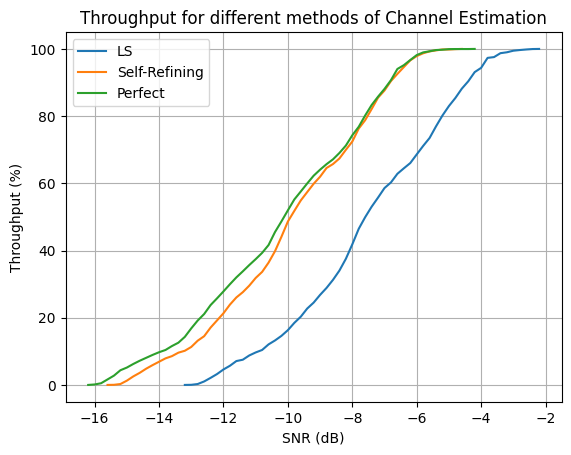

In [5]:
for i,chEstMethod in enumerate(results.keys()):
    plt.plot(results[chEstMethod][0], results[chEstMethod][2], label=chEstMethod)
plt.legend()
plt.title("Throughput for different methods of Channel Estimation");
plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("Throughput (%)")
plt.show()